# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

#### Описание данных
- `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
- `balcony` — число балконов
- `ceiling_height` — высота потолков (м)
- `cityCenters_nearest` — расстояние до центра города (м)
- `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
- `first_day_exposition` — дата публикации
- `floor` — этаж
- `floors_total` — всего этажей в доме
- `is_apartment` — апартаменты (булев тип)
- `kitchen_area` — площадь кухни в квадратных метрах (м²)
- `last_price` — цена на момент снятия с публикации
- `living_area` — жилая площадь в квадратных метрах (м²)
- `locality_name` — название населённого пункта
- `open_plan` — свободная планировка (булев тип)
- `parks_around3000` — число парков в радиусе 3 км
- `parks_nearest` — расстояние до ближайшего парка (м)
- `ponds_around3000` — число водоёмов в радиусе 3 км
- `ponds_nearest` — расстояние до ближайшего водоёма (м)
- `rooms` — число комнат
- `studio` — квартира-студия (булев тип)
- `total_area` — общая площадь квартиры в квадратных метрах (м²)
- `total_images` — число фотографий квартиры в объявлении

## Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import numpy as np
import os

# pip install scikit-learn==1.1.3
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

In [2]:
try:
    path = os.path.join('/datasets/real_estate_data.csv')
    data = pd.read_csv(path, sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)

In [3]:
display(data.head())
display(data.tail())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,"13,000,000.00",108.00,2019-03-07T00:00:00,3,2.70,16.00,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,"18,863.00","16,028.00",1.00,482.00,2.00,755.00,NaN
1,7,"3,350,000.00",40.40,2018-12-04T00:00:00,1,NaN,11.00,18.60,1,NaN,False,False,11.00,2.00,посёлок Шушары,"12,817.00","18,603.00",0.00,NaN,0.00,NaN,81.00
2,10,"5,196,000.00",56.00,2015-08-20T00:00:00,2,NaN,5.00,34.30,4,NaN,False,False,8.30,0.00,Санкт-Петербург,"21,741.00","13,933.00",1.00,90.00,2.00,574.00,558.00
3,0,"64,900,000.00",159.00,2015-07-24T00:00:00,3,NaN,14.00,NaN,9,NaN,False,False,NaN,0.00,Санкт-Петербург,"28,098.00","6,800.00",2.00,84.00,3.00,234.00,424.00
4,2,"10,000,000.00",100.00,2018-06-19T00:00:00,2,3.03,14.00,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,"31,856.00","8,098.00",2.00,112.00,1.00,48.00,121.00


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23694,9,"9,700,000.00",133.81,2017-03-21T00:00:00,3,3.70,5.00,73.30,3,NaN,False,False,13.83,NaN,Санкт-Петербург,"24,665.00","4,232.00",1.00,796.00,3.00,381.00,NaN
23695,14,"3,100,000.00",59.00,2018-01-15T00:00:00,3,NaN,5.00,38.00,4,NaN,False,False,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.00
23696,18,"2,500,000.00",56.70,2018-02-11T00:00:00,2,NaN,3.00,29.70,1,NaN,False,False,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,"11,475,000.00",76.75,2017-03-28T00:00:00,2,3.00,17.00,NaN,12,NaN,False,False,23.30,2.00,Санкт-Петербург,"39,140.00","10,364.00",2.00,173.00,3.00,196.00,602.00
23698,4,"1,350,000.00",32.30,2017-07-21T00:00:00,1,2.50,5.00,12.30,1,NaN,False,False,9.00,NaN,поселок Новый Учхоз,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,"23,699.00","23,699.00","23,699.00","23,699.00","14,504.00","23,613.00","21,796.00","23,699.00","21,421.00","12,180.00","18,157.00","18,180.00","18,181.00","8,079.00","18,181.00","9,110.00","20,518.00"
mean,9.86,"6,541,548.77",60.35,2.07,2.77,10.67,34.46,5.89,10.57,1.15,"28,793.67","14,191.28",0.61,490.80,0.77,517.98,180.89
std,5.68,"10,887,013.27",35.65,1.08,1.26,6.60,22.03,4.89,5.91,1.07,"12,630.88","8,608.39",0.80,342.32,0.94,277.72,219.73
min,0.00,"12,190.00",12.00,0.00,1.00,1.00,2.00,1.00,1.30,0.00,0.00,181.00,0.00,1.00,0.00,13.00,1.00
25%,6.00,"3,400,000.00",40.00,1.00,2.52,5.00,18.60,2.00,7.00,0.00,"18,585.00","9,238.00",0.00,288.00,0.00,294.00,45.00
50%,9.00,"4,650,000.00",52.00,2.00,2.65,9.00,30.00,4.00,9.10,1.00,"26,726.00","13,098.50",0.00,455.00,1.00,502.00,95.00
75%,14.00,"6,800,000.00",69.90,3.00,2.80,16.00,42.30,8.00,12.00,2.00,"37,273.00","16,293.00",1.00,612.00,1.00,729.00,232.00
max,50.00,"763,000,000.00",900.00,19.00,100.00,60.00,409.70,33.00,112.00,5.00,"84,869.00","65,968.00",3.00,"3,190.00",3.00,"1,344.00","1,580.00"


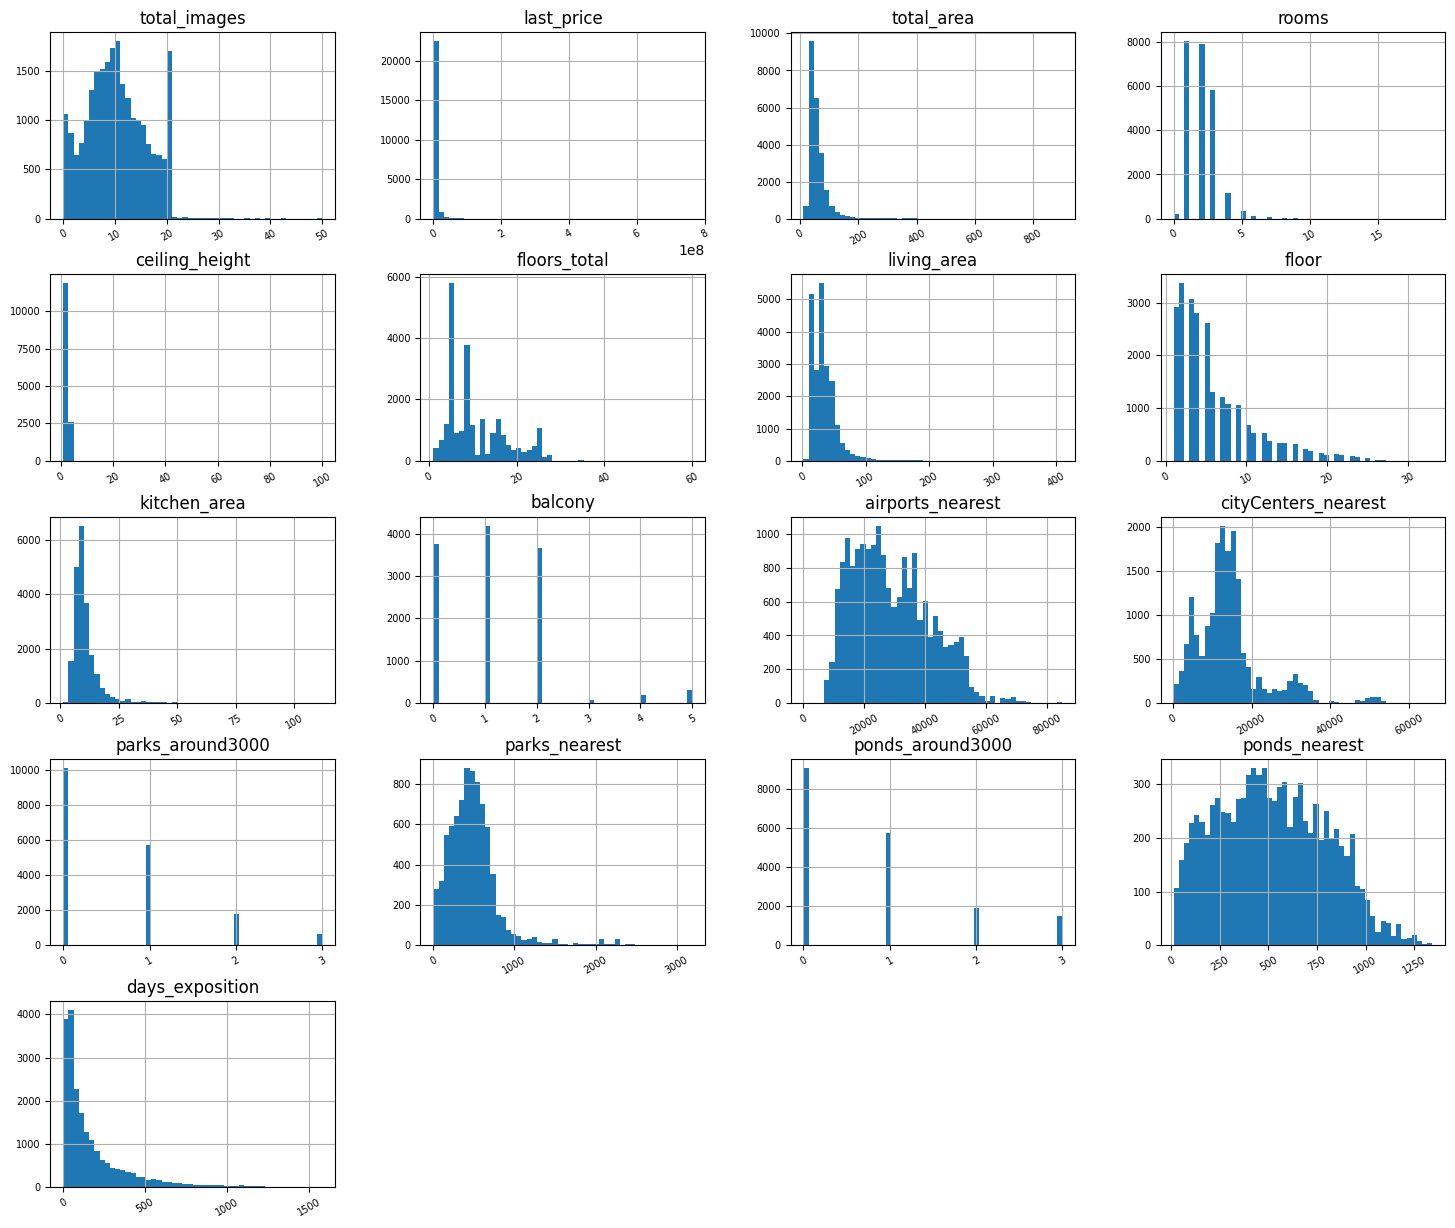

In [6]:
data.hist(bins=50, figsize=(18, 15), xlabelsize=7, xrot=30, ylabelsize=7);

### выводы:
- в столбцах присутствует верблюжий регистр и не все названия хорошо описывают суть, стоит их переименовать
- хотелось бы удобнее сгрупировать столбцы, для того чтобы было удобнее анализировать данные
- есть много пропущенных данных в столбцах (`ceiling_height`, `floors_total`, `living_area`, `is_apartment`, `kitchen_area`, `balcony`, `locality_name`, `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`, `days_exposition`). по возможности это стоит исправить
- `is_apartment` имеет тип данных object, удобнее будет привести его к формату bool
- `first_day_exposition` переведём в формат даты
- `ceiling_height` на гистограмме есть выбросы, скорее всего ошибки в данных
- `last_price` на гистограмме имеются сильные выбросы, возможно это какая-то элитная недвижимость, а может ошибка, стоит это изучить

## Предобработка данных

### Переименуем столбцы
Названия в верблюжем регистре и другие не качественные названия. 
Столбцы булева типа переименуев в формате `is_` по аналогии со столбцом `is_apartment`.

выведем список для удобства:

In [7]:
data.columns.tolist()

['total_images',
 'last_price',
 'total_area',
 'first_day_exposition',
 'rooms',
 'ceiling_height',
 'floors_total',
 'living_area',
 'floor',
 'is_apartment',
 'studio',
 'open_plan',
 'kitchen_area',
 'balcony',
 'locality_name',
 'airports_nearest',
 'cityCenters_nearest',
 'parks_around3000',
 'parks_nearest',
 'ponds_around3000',
 'ponds_nearest',
 'days_exposition']

In [8]:
data = data.rename(columns={
    'cityCenters_nearest': 'city_centers_nearest', 
    'balcony': 'number_of_balconies', 
    'rooms': 'number_of_rooms',
    'studio': 'is_studio',
    'open_plan': 'is_open_plan'
})

data.columns.tolist()

['total_images',
 'last_price',
 'total_area',
 'first_day_exposition',
 'number_of_rooms',
 'ceiling_height',
 'floors_total',
 'living_area',
 'floor',
 'is_apartment',
 'is_studio',
 'is_open_plan',
 'kitchen_area',
 'number_of_balconies',
 'locality_name',
 'airports_nearest',
 'city_centers_nearest',
 'parks_around3000',
 'parks_nearest',
 'ponds_around3000',
 'ponds_nearest',
 'days_exposition']

### Поменяем последовательность столбцов

сгруппируем их по категориям:
- дата; 
- расположение; 
- характеристики квартиры;
- окружение;
- цена;
- фотографии

In [10]:
data = data[[
    'first_day_exposition',
    'days_exposition',
    'locality_name',
    'city_centers_nearest',
    'airports_nearest',
    'parks_nearest',
    'ponds_nearest',
    'parks_around3000',
    'ponds_around3000',
    'number_of_rooms',
    'number_of_balconies',
    'total_area',
    'living_area',
    'kitchen_area',
    'floors_total',
    'floor',
    'ceiling_height',
    'is_apartment',
    'is_studio',
    'is_open_plan',
    'last_price',
    'total_images',
]]

### Работа с пропусками

В колонке с количеством балконов много пропусков. вероятнее всего люди не заполняют это значение когда балконов нет. заполним пропуски нулями и переведём значение в целое, а то полтора балкона это что-то странное

In [11]:
data['number_of_balconies'] = data['number_of_balconies'].fillna(0).astype('int64')

Избавимся от пропусков в столбце с аппартаментами, а заодно переведём его в булев тип

In [12]:
data['is_apartment'] = data['is_apartment'].fillna(False)

Удалим строки в которых отсутствует название населённого пункта. Таких строк мало и они не сильно повлияют на выборку, и не несут пользы для исследования т.к. даже не известно о чём речь, где эта квартира

In [13]:
data.dropna(subset=['locality_name'], inplace=True)

`living_area` и `kitchen_area` имеют пропуски, заполним их средними значениями, соответствующими общей площади.
Проверим корреляцию этих параметров

'корреляция жилой площади к общей равна: 0.94'

'корреляция площади кухни к общей площади равна:  0.61'

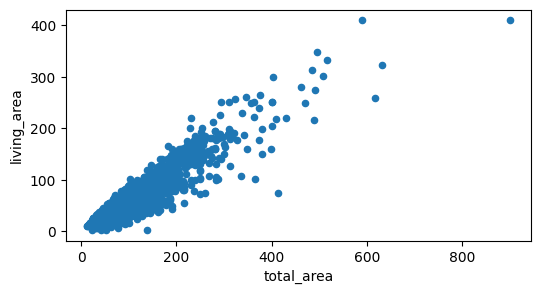

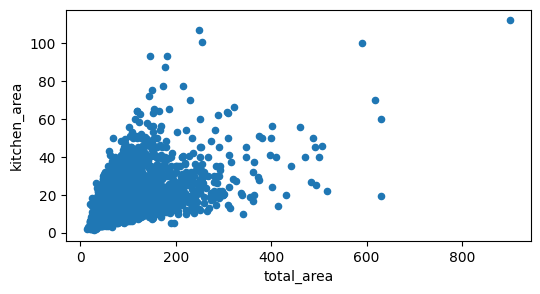

In [14]:
data.plot(x='total_area', y='living_area', kind='scatter', figsize=(6, 3))
data.plot(x='total_area', y='kitchen_area', kind='scatter', figsize=(6, 3))

living_area_to_total_corr = data['total_area'].corr(data['living_area'])
kitchen_area_to_total_corr = data['total_area'].corr(data['kitchen_area'])

display(f'корреляция жилой площади к общей равна: {living_area_to_total_corr:.2f}')
display(f'корреляция площади кухни к общей площади равна:  {kitchen_area_to_total_corr:.2f}')

Корреляция положительная, видна отчётлива, думаю что заполнение пропущенных данных с опорой на общую площадь вполне подойдёт.
используем метод [MissForest](https://towardsdatascience.com/missforest-the-best-missing-data-imputation-algorithm-4d01182aed3 "MissForest")

In [15]:
# возьмём срез из трёх столбцов с площадями
areas_imput = data.loc[:,'total_area':'kitchen_area']

# применим метод для заполнения NaN значений
imputer = MissForest()
areas_imput = imputer.fit_transform(areas_imput)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [16]:
# заменим столбцы в датасете на столбцы без пропусков и округлим их до целочисленных
data['living_area'] = areas_imput[:, 1]
data['kitchen_area'] = areas_imput[:, 2]

Проверим не появилось ли на диаграммах рессеяния аномальных выбросов:

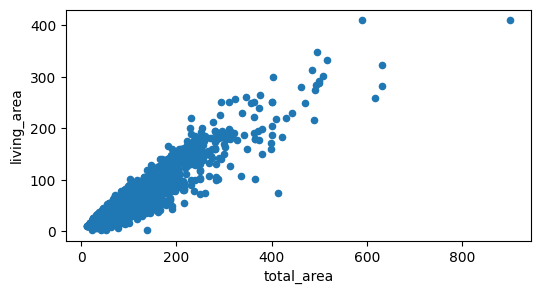

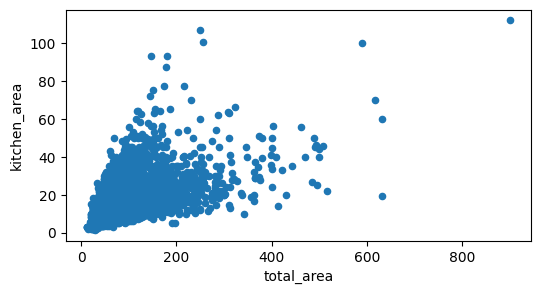

In [17]:
data.plot(x='total_area', y='living_area', kind='scatter', figsize=(6, 3))
data.plot(x='total_area', y='kitchen_area', kind='scatter', figsize=(6, 3));

Нет, все новые точки легли в тот-же диапозон, алгоритм отреботал как надо

Этим же методом заполним несколько недостающих ячеек в количестве этажей

In [18]:
# возьмём срез из столбцов с этажем
floors_imput = data.loc[:,'floors_total':'floor',]

# применим метод для заполнения NaN значений
floors_imput = imputer.fit_transform(floors_imput)

Iteration: 0
Iteration: 1
Iteration: 2


In [19]:
# заменим столбец в датасете на столбец без пропусков и округлим до целочисленных
data['floors_total'] = np.round(floors_imput[:, 0], 0).astype('int64')

Посмотрим на гистограмму зависимости чтобы убедится что метод не выдал нам значений с количеством этажей дома меньше чем этаж на котором находится квартира

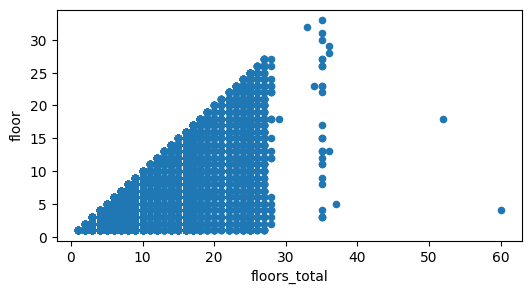

In [20]:
data.plot(x='floors_total', y='floor', kind='scatter', figsize=(6, 3));

Видим прямую линию под 45 градусов, сверху ничего нет, следовательно квартир на этажах выше этажности дома нет, алгоритм не выдал аномальных значений и опять сработал корректно

Посмотрим на оставшиеся пропуски

In [21]:
data.isnull().sum().sort_values(ascending=False)/data.shape[0]*100

parks_nearest          65.90
ponds_nearest          61.59
ceiling_height         38.73
airports_nearest       23.40
city_centers_nearest   23.30
parks_around3000       23.30
ponds_around3000       23.30
days_exposition        13.45
first_day_exposition    0.00
floor                   0.00
last_price              0.00
is_open_plan            0.00
is_studio               0.00
is_apartment            0.00
total_area              0.00
floors_total            0.00
kitchen_area            0.00
living_area             0.00
number_of_balconies     0.00
number_of_rooms         0.00
locality_name           0.00
total_images            0.00
dtype: float64

По всей видимости это просто не заполненные поля, не все люди хотят заполнять высоту потолков, растояние до парков и прудов.
не понятна природа пропусков в столбце с временем публикации объявления. это выглядит ошибкой, либо технической, либо человеческий фактор при работе с данными, но эти данные по хорошему должны генерироватся автоматически.
Запомним это и пока продолжим анализ с этими пропусками, вероятно это не так критично

### Исправление типов данных

Выше, в ходе работы с пропусками, параллельно мы уже исправили некоторые столбцы, округлив в них значения до целочисленных, и колонку аппартаментов сделали типом bool. Посмотрим на оставшиеся:

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   first_day_exposition  23650 non-null  object 
 1   days_exposition       20470 non-null  float64
 2   locality_name         23650 non-null  object 
 3   city_centers_nearest  18139 non-null  float64
 4   airports_nearest      18116 non-null  float64
 5   parks_nearest         8064 non-null   float64
 6   ponds_nearest         9085 non-null   float64
 7   parks_around3000      18140 non-null  float64
 8   ponds_around3000      18140 non-null  float64
 9   number_of_rooms       23650 non-null  int64  
 10  number_of_balconies   23650 non-null  int64  
 11  total_area            23650 non-null  float64
 12  living_area           23650 non-null  float64
 13  kitchen_area          23650 non-null  float64
 14  floors_total          23650 non-null  int64  
 15  floor                 23

`first_day_exposition` переведём в формат даты. пример старого формата: 2017-03-21T00:00:00

In [23]:
data['first_day_exposition'] = pd.to_datetime(
    data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S'
)
display(data['first_day_exposition'].head())

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]

Обращаем внимание что указаны только даты, время отсутствует

### Проверим дубликаты

In [24]:
data.duplicated().sum()

0

Явных дубликатов нет, стоит проверить названия населённых пунктов

In [25]:
len(data['locality_name'].unique())

364

In [26]:
data['locality_name'].unique().tolist()

['Санкт-Петербург',
 'посёлок Шушары',
 'городской посёлок Янино-1',
 'посёлок Парголово',
 'посёлок Мурино',
 'Ломоносов',
 'Сертолово',
 'Петергоф',
 'Пушкин',
 'деревня Кудрово',
 'Коммунар',
 'Колпино',
 'поселок городского типа Красный Бор',
 'Гатчина',
 'поселок Мурино',
 'деревня Фёдоровское',
 'Выборг',
 'Кронштадт',
 'Кировск',
 'деревня Новое Девяткино',
 'посёлок Металлострой',
 'посёлок городского типа Лебяжье',
 'посёлок городского типа Сиверский',
 'поселок Молодцово',
 'поселок городского типа Кузьмоловский',
 'садовое товарищество Новая Ропша',
 'Павловск',
 'деревня Пикколово',
 'Всеволожск',
 'Волхов',
 'Кингисепп',
 'Приозерск',
 'Сестрорецк',
 'деревня Куттузи',
 'посёлок Аннино',
 'поселок городского типа Ефимовский',
 'посёлок Плодовое',
 'деревня Заклинье',
 'поселок Торковичи',
 'поселок Первомайское',
 'Красное Село',
 'посёлок Понтонный',
 'Сясьстрой',
 'деревня Старая',
 'деревня Лесколово',
 'посёлок Новый Свет',
 'Сланцы',
 'село Путилово',
 'Ивангород',
 '

364 названия. На первый взгляд оценить сложно, но стоит для начала попробовать перевести всё в нижний регистр.
И тут точно есть проблема с буквой Ё

In [27]:
data['locality_name'] = data['locality_name'].str.lower()
len(data['locality_name'].unique())

364

In [28]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е', regex=True)
len(data['locality_name'].unique())

330

Нижней регистр не избавил нас от дубликатов, а вот когда мы убрали Ё, нашлось целых 34 дублирующих названия, это уже результат.
Попробуем ещё сократить названия типов поселения:

In [29]:
data['locality_name'] = data['locality_name'].str.replace('садоводческое некоммерческое товарищество', 'садовое товарищество', regex=True)
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа', 'поселок', regex=True)
data['locality_name'] = data['locality_name'].str.replace('коттеджный поселок', 'поселок', regex=True)
data['locality_name'] = data['locality_name'].str.replace('городской поселок', 'поселок', regex=True)
data['locality_name'] = data['locality_name'].str.replace('поселок станции', 'поселок', regex=True)
data['locality_name'] = data['locality_name'].str.replace('поселок при железнодорожной станции', 'поселок', regex=True)

In [30]:
len(data['locality_name'].unique())

318

Ещё 12 дуликатов

### Разберёмся с аномальными значениями в столбце с высотой потолков. 

По всей видимости некоторые значения были записаны без запятой. Проверим эту гипотезу, посмотрим на гистограмму

<Axes: >

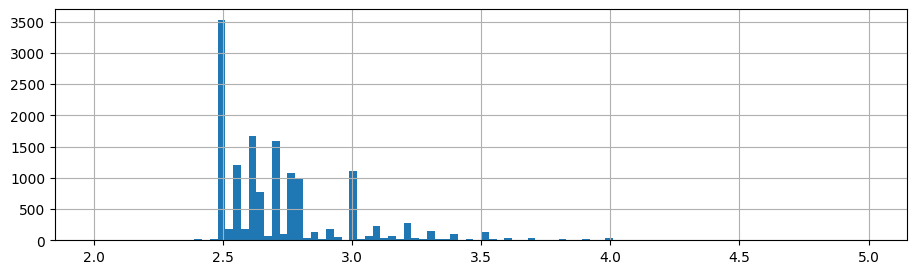

In [31]:
data['ceiling_height'].hist(bins=100, range=(2, 5), figsize=(11, 3))

Абсолютное большинство квартир начинаются с высоты потолков в 2.5 метра. приблизим гистограмму в области 25 м

<Axes: >

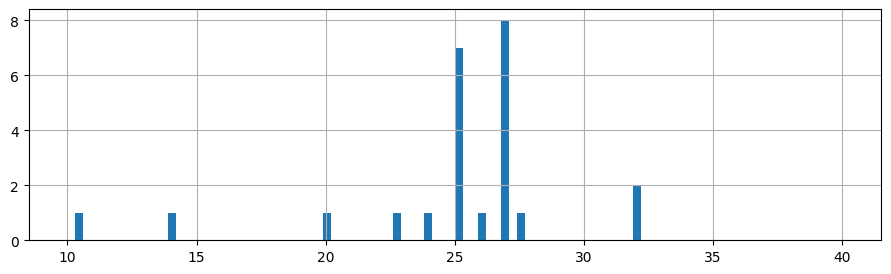

In [32]:
data['ceiling_height'].hist(bins=100, range=(10, 40), figsize=(11, 3))

Похоже что наша гипотеза верна, имеется всплеск на 25 метрах, ровно в 10 раз больше. Исправим это

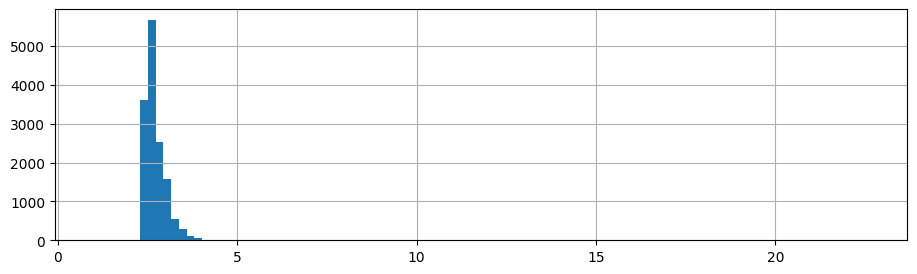

In [33]:
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] < 23, data['ceiling_height']/10)
data['ceiling_height'].hist(bins=100, figsize=(11, 3));

По прежнему есть выброс до более 20 метров, избавимся от них

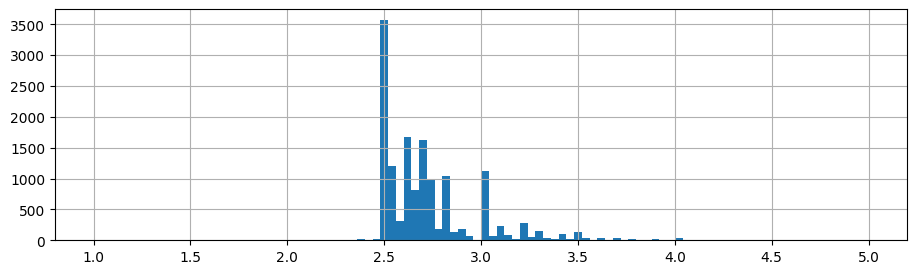

In [34]:
data = data.drop(data[data['ceiling_height'] > 5].index)
data['ceiling_height'].hist(bins=100, figsize=(11, 3));

### Разберёмся с аномальными значениями в столбце с ценой

Для начала отформатируем формат цены, переведем его в миллионы для удобства

In [35]:
data['last_price'] = data['last_price'] / 1000000

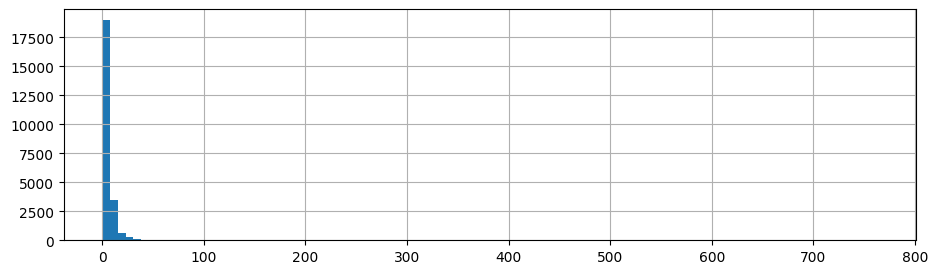

In [36]:
data['last_price'].hist(bins=100, figsize=(11, 3));

Выбросы вплоть до 800 миллионов за квартиру, примерно после 50 миллионов количество квартир незначительно, избавимся от этих выбросов

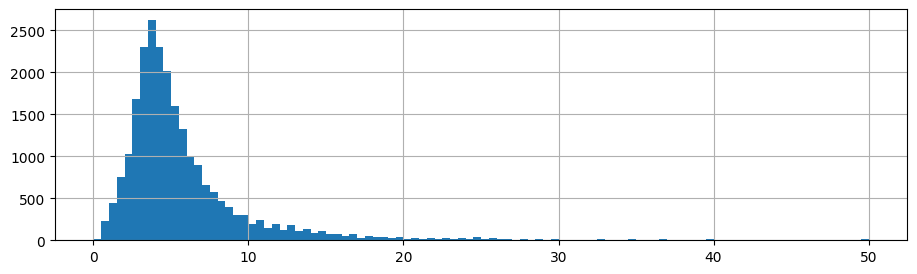

In [37]:
data = data.drop(data[data['last_price'] > 50].index)
data['last_price'].hist(bins=100, figsize=(11, 3));

### Разберёмся с аномальными значениями в столбце количеством комнат

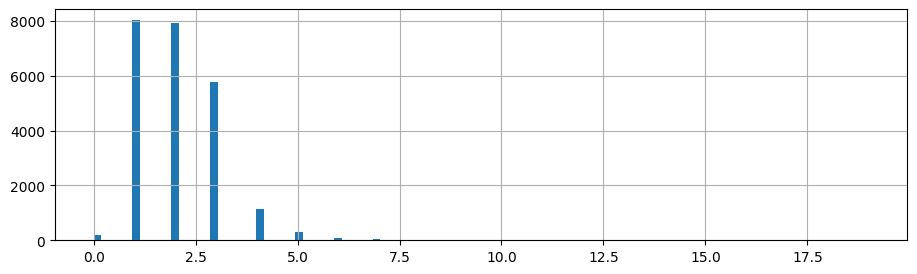

In [38]:
data['number_of_rooms'].hist(bins=100, figsize=(11, 3));

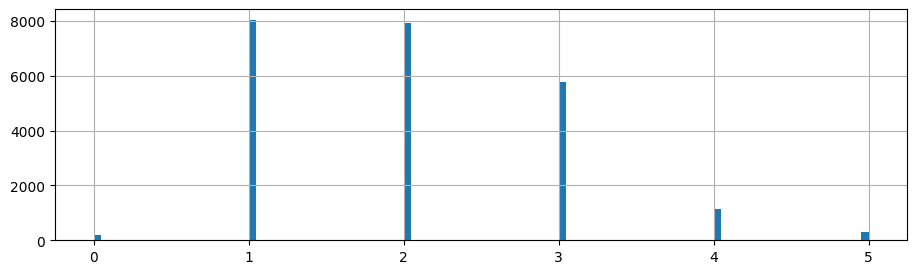

In [39]:
data = data.drop(data[data['number_of_rooms'] > 5].index)
data['number_of_rooms'].hist(bins=100, figsize=(11, 3));

### Разберёмся с аномальными значениями в столбце с площадью

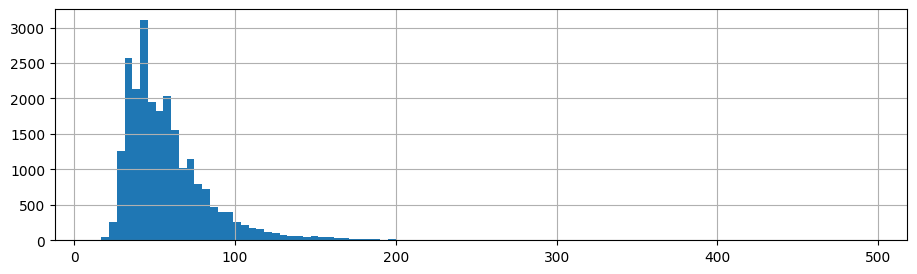

In [40]:
data['total_area'].hist(bins=100, figsize=(11, 3));

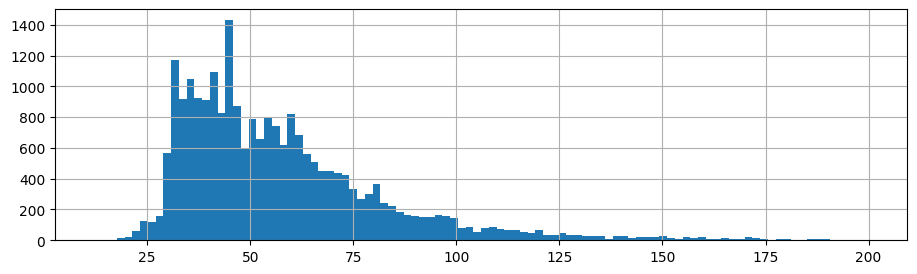

In [41]:
data = data.drop(data[data['total_area'] > 200].index)
data['total_area'].hist(bins=100, figsize=(11, 3));

## Посчитаем и добавим в таблицу новые столбцы

Добавим столбец с ценой за квадратный метр

In [42]:
data['price_for_m2'] = data['last_price']/data['total_area']*1000000

Добавим стололбец с днём недели публикации объявления

In [43]:
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday

Добавим стололбец с месяцем публикации объявления

In [44]:
data['month_exposition'] = data['first_day_exposition'].dt.month

Добавим стололбец с годом публикации объявления

In [45]:
data['year_exposition'] = data['first_day_exposition'].dt.year

Добавим стололбец с типом этажа

In [46]:
def floor_type(df):
    if df['floor'] == 1:
        return 'первый'
    elif df['floor'] == df['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
data['floor_type'] = data.apply(floor_type, axis=1)

Переведём расстояния километры и добавим как новый столбец

In [47]:
data['city_centers_nearest_km'] = np.round(data['city_centers_nearest'] / 1000, 0)

## Проведите исследовательский анализ данных

### Общая площадь

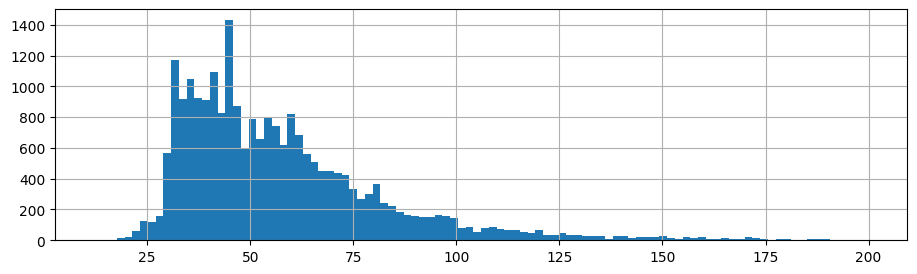

In [48]:
data['total_area'].hist(bins=100, figsize=(11, 3));

Общая площадь начинается около 30 метров, имеет пик в районе 50 метров и постепенно спадает к 150 метрам

### Жилая площадь

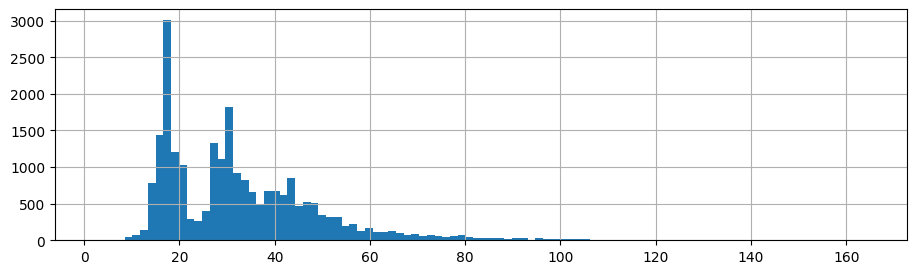

In [49]:
data['living_area'].hist(bins=100, figsize=(11, 3));

Пики возле 18 и 30 метров. Видно ещё небольшой пик возле 43м. Мы заполняли пустые ячейки в этом столбце, но два пика было и в выводе гистограмм в начале работы, на сырых данных, так что нашу ошибку мы исключаем. Можно предположить что на этих пиках находятся 1-на, 2-х и 3-х комнатные квартиры. Если это так, то скорее всего мы увидим пик на однокомнатных квартирах в гистограмме распределения по количеству комнат

### Площадь кухни

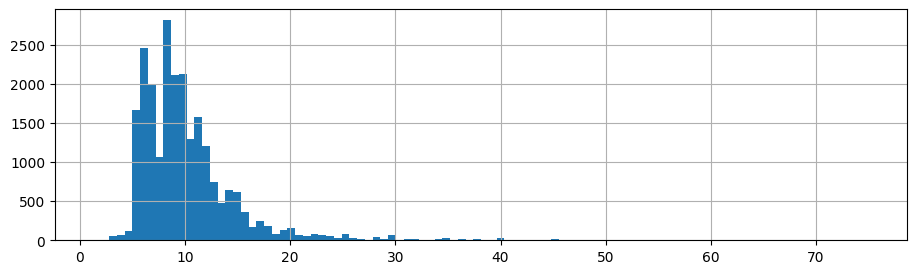

In [50]:
data['kitchen_area'].hist(bins=100, figsize=(11, 3));

Есть пик от 6 до 10 метров и выбросы до сотни метров

### Цена объекта

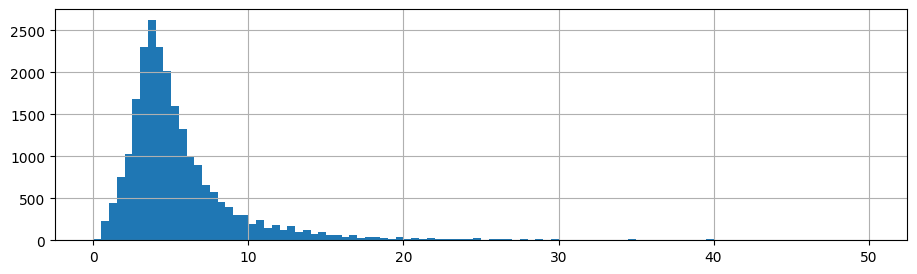

In [51]:
data['last_price'].hist(bins=100, figsize=(11, 3));

Нормальное распределение, с пиком возле 4 миллионов и хвостом уходящимв сторону богатой жизни =)

### Количество комнат

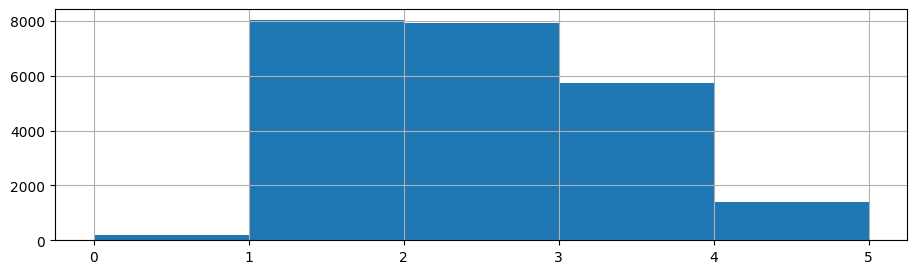

In [52]:
data['number_of_rooms'].hist(bins = data['number_of_rooms'].max(), figsize=(11, 3));

Больше всего 1-комнатных квартир, немногим меньше 2-комнатных, после 4-5 комнат есть хвост, но количество таких объявлений очень меленькое. Есть так же значение 0. Возможно это квартиры студии. проверим:

In [53]:
data.loc[data['number_of_rooms'] == 0, 'number_of_rooms'].count()

195

In [54]:
data.loc[(data['number_of_rooms'] == 0) & (data['is_studio'] == True), 'number_of_rooms'].count()

137

Как правило да, но не все. посмотрим на оставшиеся

In [55]:
data.loc[(data['number_of_rooms'] == 0) & (data['is_studio'] == False)]

,first_day_exposition,days_exposition,locality_name,city_centers_nearest,airports_nearest,parks_nearest,ponds_nearest,parks_around3000,ponds_around3000,number_of_rooms,number_of_balconies,total_area,living_area,kitchen_area,floors_total,floor,ceiling_height,is_apartment,is_studio,is_open_plan,last_price,total_images,price_for_m2,weekday_exposition,month_exposition,year_exposition,floor_type,city_centers_nearest_km
349,2017-09-27,45.00,деревня кудрово,NaN,NaN,NaN,NaN,NaN,NaN,0,0,25.00,17.00,4.85,14,1,NaN,False,False,True,2.32,4,"92,800.00",2,9,2017,первый,NaN
508,2017-03-28,430.00,поселок парголово,"19,292.00","53,115.00",NaN,593.00,0.00,1.00,0,1,34.40,24.30,7.48,26,19,NaN,False,False,True,3.38,0,"98,110.47",1,3,2017,другой,19.00
780,2018-02-20,45.00,поселок мурино,NaN,NaN,NaN,NaN,NaN,NaN,0,1,26.10,17.18,5.28,18,8,NaN,False,False,True,2.60,9,"99,616.86",1,2,2018,другой,NaN
839,2017-04-14,7.00,поселок новый свет,NaN,NaN,NaN,NaN,NaN,NaN,0,1,35.00,15.00,9.63,5,3,2.70,False,False,True,1.90,14,"54,285.71",4,4,2017,другой,NaN
946,2016-09-27,483.00,поселок мурино,NaN,NaN,NaN,NaN,NaN,NaN,0,2,23.00,18.00,4.48,27,7,NaN,False,False,True,2.20,5,"95,652.17",1,9,2016,другой,NaN
1574,2017-11-03,81.00,деревня кудрово,NaN,NaN,NaN,NaN,NaN,NaN,0,1,22.00,15.00,5.30,18,16,NaN,False,False,True,2.20,0,"100,000.00",4,11,2017,другой,NaN
1625,2018-02-01,120.00,поселок корнево,NaN,NaN,NaN,NaN,NaN,NaN,0,1,23.98,10.50,6.16,4,3,NaN,False,False,True,1.98,7,"82,568.81",3,2,2018,другой,NaN
2532,2018-02-01,70.00,санкт-петербург,"8,175.00","32,036.00",NaN,644.00,0.00,1.00,0,2,27.10,18.70,3.83,18,9,NaN,False,False,True,3.50,5,"129,151.29",3,2,2018,другой,8.00
3019,2017-11-10,5.00,сертолово,NaN,NaN,NaN,NaN,NaN,NaN,0,2,24.00,18.00,6.27,10,6,NaN,False,False,True,2.10,18,"87,500.00",4,11,2017,другой,NaN
4115,2018-02-01,42.00,санкт-петербург,"13,330.00","10,031.00",915.00,NaN,1.00,0.00,0,2,24.00,18.00,6.27,25,4,NaN,False,False,True,2.60,7,"108,333.33",3,2,2018,другой,13.00


Все они Открытого плана, вот и ответ откуда у нас недвижимость с 0 комнатами.

### Высота потолков

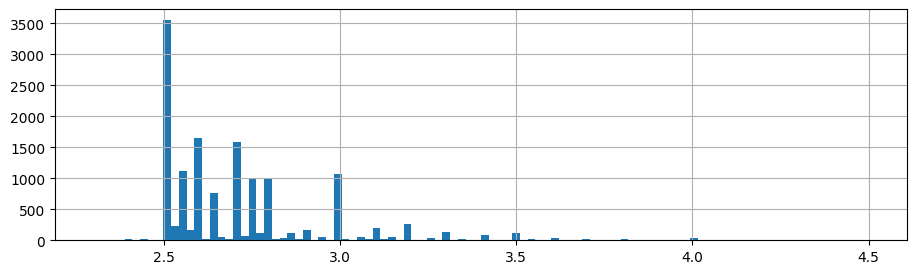

In [56]:
data['ceiling_height'].hist(bins=100, figsize=(11, 3), range=(2.3, 4.5));

Мы имеем пик на 2.5 матрах, некоторое весомое количество значений  между 2.5 и 3 метрами и жильё с поталками выше 3 метров уже редкость

### Этаж квартиры

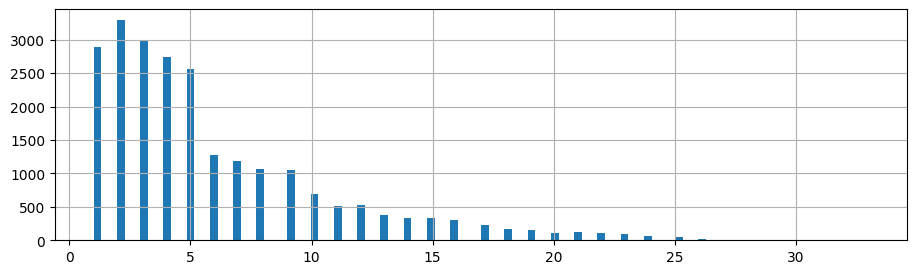

In [57]:
data['floor'].hist(bins=100, figsize=(11, 3));

Большинство квартир на 1-5 этаже, видимо хрущёвки влияют на статистику

### Тип этажа квартиры («первый», «последний», «другой»)

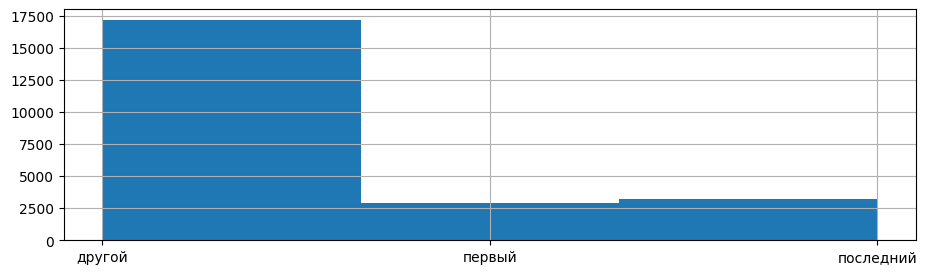

In [58]:
data['floor_type'].hist(bins=3, figsize=(11, 3));

Лидирует у нас "другой", а первый и последний примерно равны друг другу, картина вполне ожидаемая, идём дальше

### Общее количество этажей в доме

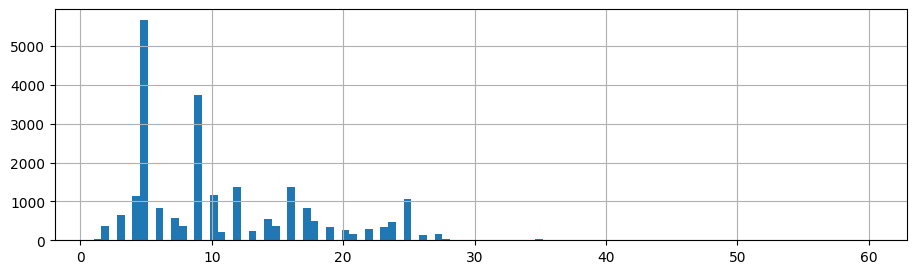

In [59]:
data['floors_total'].hist(bins=100, figsize=(11, 3));

И тут опять хрущевки дают о себе знать, имеется пик на 5 этажках, а так же 9 этажки, тоже частый тип домов. Есть выбросы до 60, небоскрёбы в питере бывают, представить такое можно, анамалий скорее всего тут нет

### Расстояние до центра города

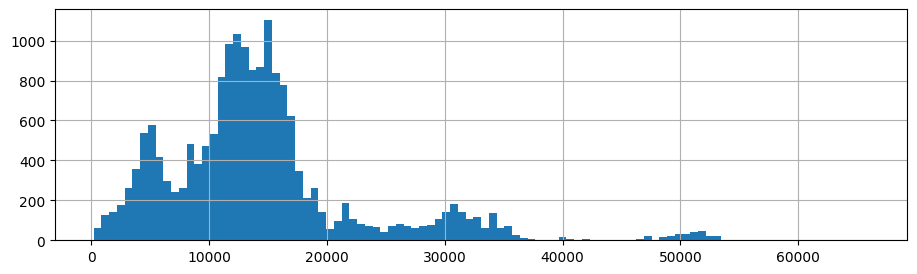

In [60]:
data['city_centers_nearest'].hist(bins=100, figsize=(11, 3));

Есть два крупных пика, на 5км и на 12 км. по всей видимости один пик это питер и расстояния до его центра, а так как он большой, то расстояния там значительно больше чем в окрестных городах, следовательно пик в 12 км это скорее всего по большей части питер, а пик поменьше, это влияние других городов. небольшой подъём возле 30 км, это скорее всего загородная недвижимость и указано расстояние до центра Питера.

### Расстояние до ближайшего аэропорта

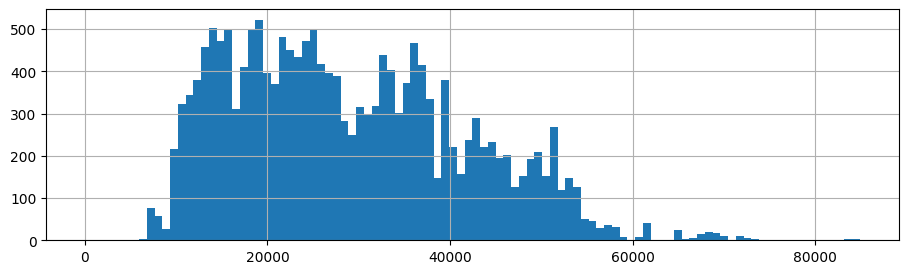

In [61]:
data['airports_nearest'].hist(bins=100, figsize=(11, 3));

Рядом с ээропортом почти никто не живёт (или не хочет об этом говорить в объявлении). далее распределение правдоподобное с учётом того что до Пулково от центра Питера около 15 км, как раз там и находится основное скопление предложений

### Расстояние до ближайшего парка

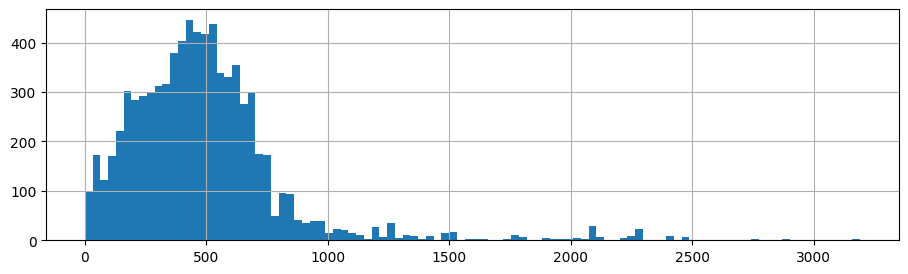

In [62]:
data['parks_nearest'].hist(bins=100, figsize=(11, 3));

Основная масса парков находится примерно 500 м от жилья, а кто-то живёт прямо в парке =)

Но стоит помнить что в 2/3 объявлений не указано расстояние до парка, или не указали или парка рядом нет

### День и месяц публикации объявления

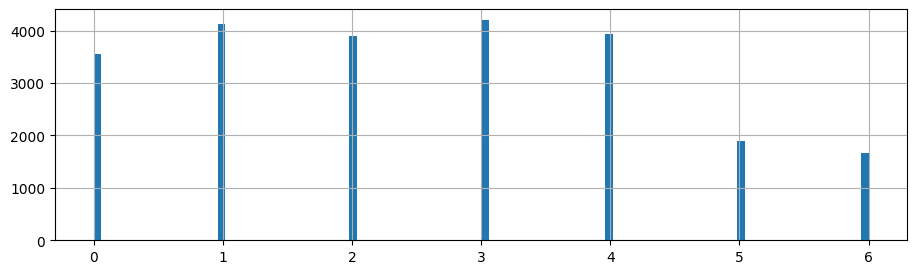

In [63]:
data['weekday_exposition'].hist(bins=100, figsize=(11, 3));

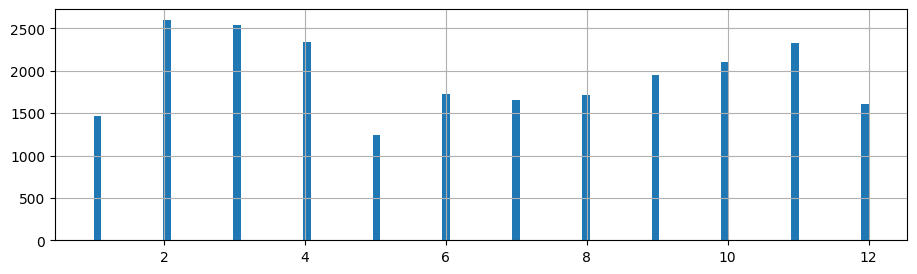

In [64]:
data['month_exposition'].hist(bins=100, figsize=(11, 3));

Видны спады на выходных, в выходные большинству не до волокиты с объявлениями видимо.

Так же есть спад в январе и мае, что тоже объясняется большим количеством выходных и отпусков. Летом объявления дают реже, а самый пик это весна, особенно февраль

### Изучим, как быстро продавались квартиры

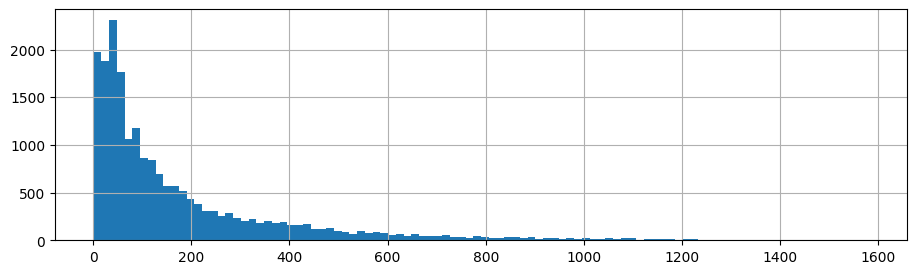

In [65]:
data['days_exposition'].hist(bins=100, figsize=(11, 3));

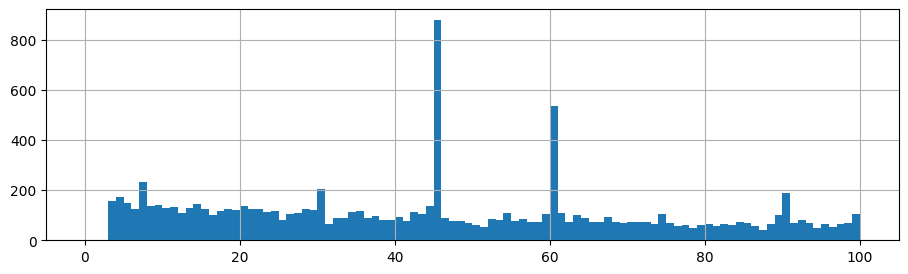

In [66]:
data['days_exposition'].hist(bins=100, figsize=(11, 3), range=(0, 100));

In [67]:
data['days_exposition'].describe()

count   20,191.00
mean       179.09
std        218.01
min          1.00
25%         45.00
50%         94.00
75%        228.00
max      1,580.00
Name: days_exposition, dtype: float64

Распределение имеет форму распределения Пуассона, средний показатель пол года, но так как на гистограмме у нас есть очень большие выбросы, а большая часть данных лежит в диапозоне до 231 дня, то среднее значение тут плохо передаёт картину. медиана же подходит больше и медиана равна 95 дням. так же мы имеем пики на 45 и 60 дней, скорее всего это какае-то стандартное количество дней на которые даётся объявление

### Изучим какие факторы больше всего влияют на общую (полную) стоимость объекта

Сгруппируем разные параметры и построим графики для изучения их влияни на цену

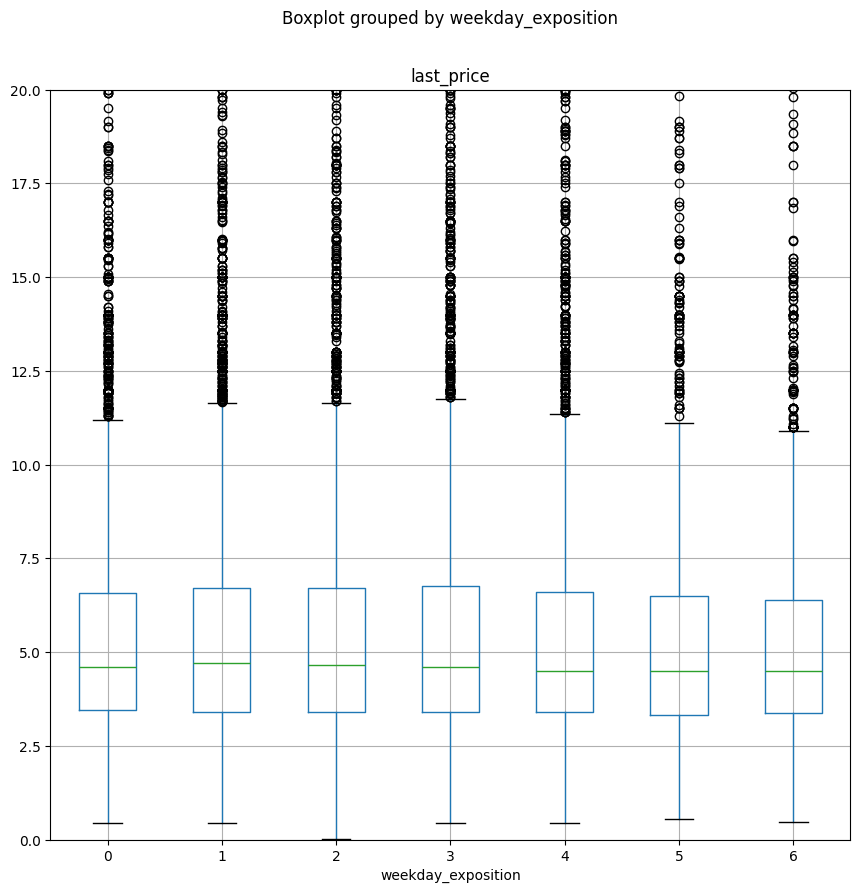

In [68]:
plot = data.boxplot('last_price', by='weekday_exposition',figsize=(10,10)).set_ylim(0,20)

Цена слабо зависит от дня недели публикации обявления, отклонения в пределах погрешности

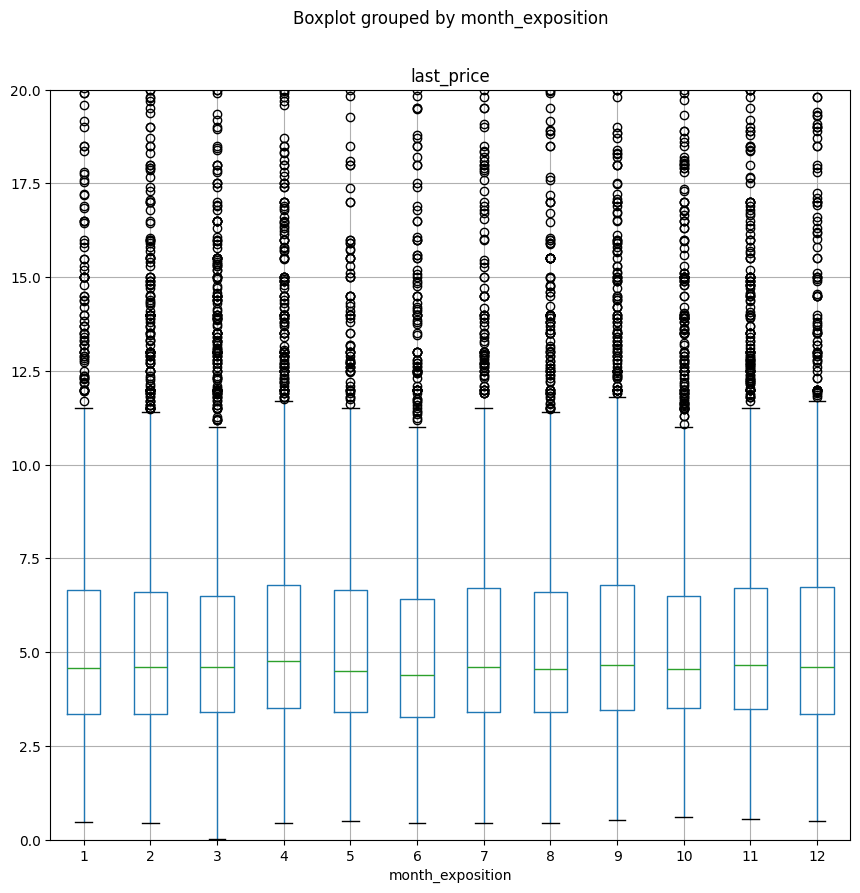

In [69]:
plot = data.boxplot('last_price', by='month_exposition',figsize=(10,10)).set_ylim(0,20)

Похожая ситуация с месяцем, отклонения минимальны

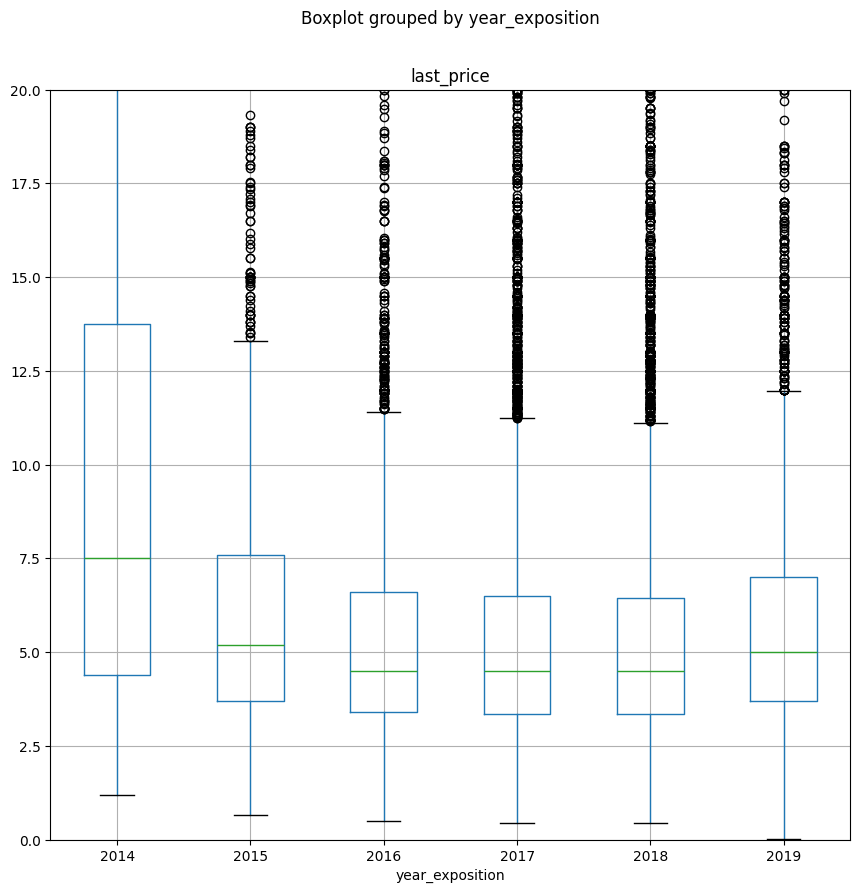

In [70]:
plot = data.boxplot('last_price', by='year_exposition',figsize=(10,10)).set_ylim(0,20)

А вот по годам уже есть зависимость, медианная цена в 2014 году была выше 7.5 млн и снижалась до 2016 года, продержалась на этом уровне 3 годе и в 2019 опять выросла

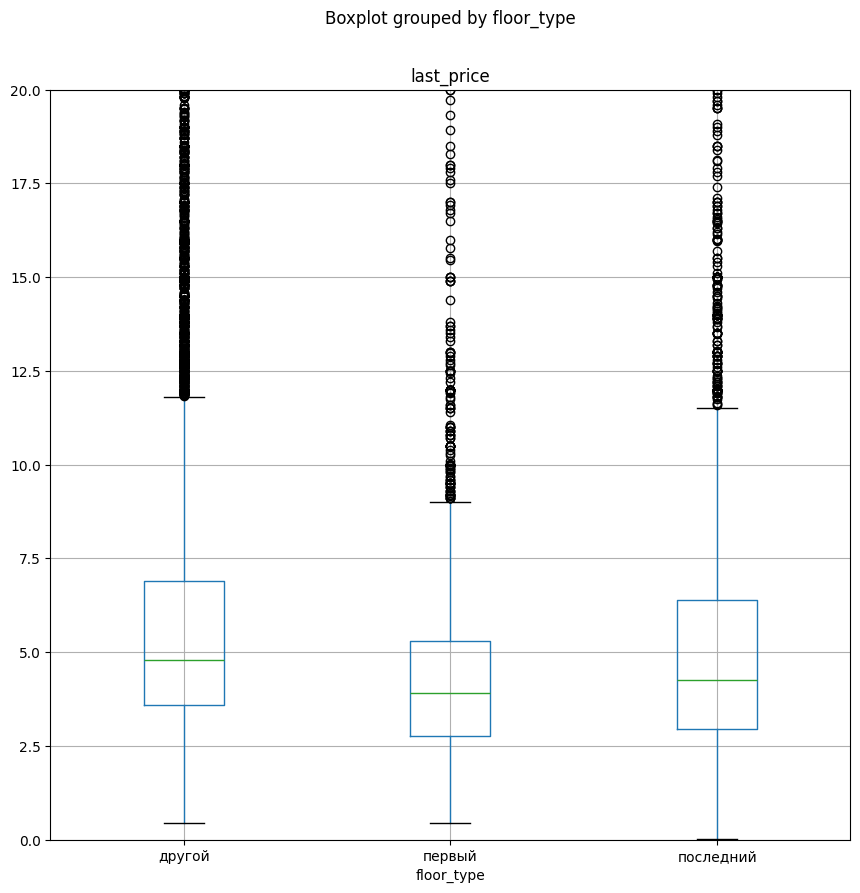

In [71]:
plot = data.boxplot('last_price', by='floor_type',figsize=(10,10)).set_ylim(0,20)

Квартиры на первом этаже стоят дешевле. Если бы мы смотрели только медиану, то разница с последним была бы маленькой, но из ящиков с усами видно что интервальный размах смещён вниз, в сторону более дешовых цен.

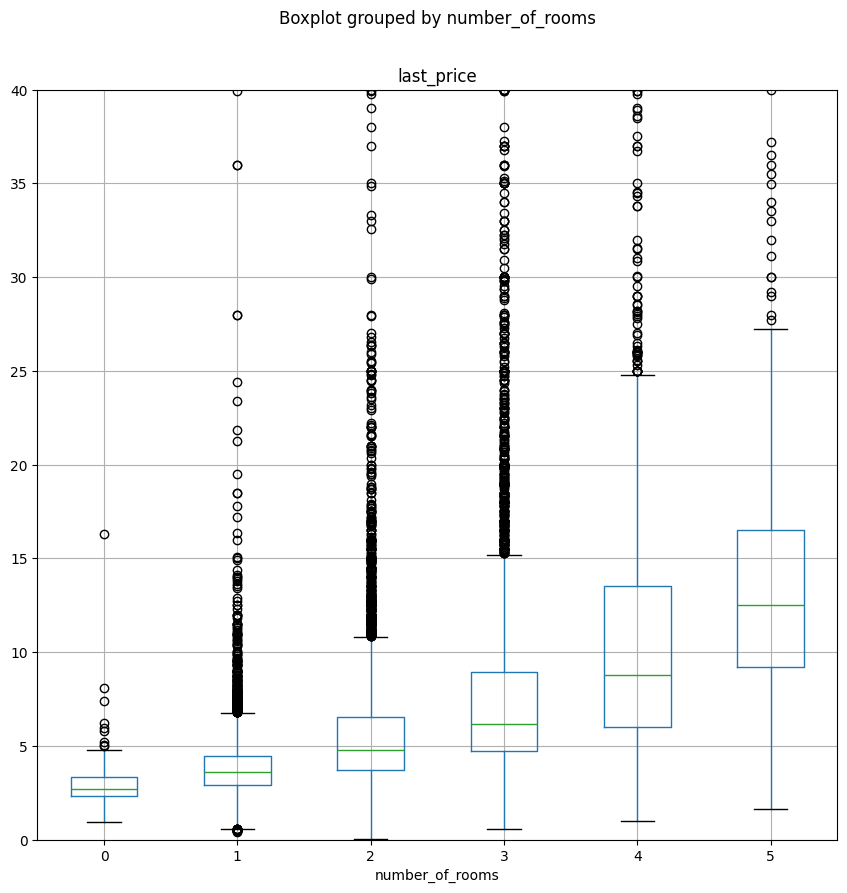

In [72]:
plot = data.boxplot('last_price', by='number_of_rooms',figsize=(10,10)).set_ylim(0,40)

Тут зависимость огромная, даже пришлось диапозон увеличивать, который отсекал выбросы, теперь мы видим что формировало эти выбросы - квартиры с большим количеством комнат стоят пропорционально дороже, вплоть до разницы цен на порядок выше

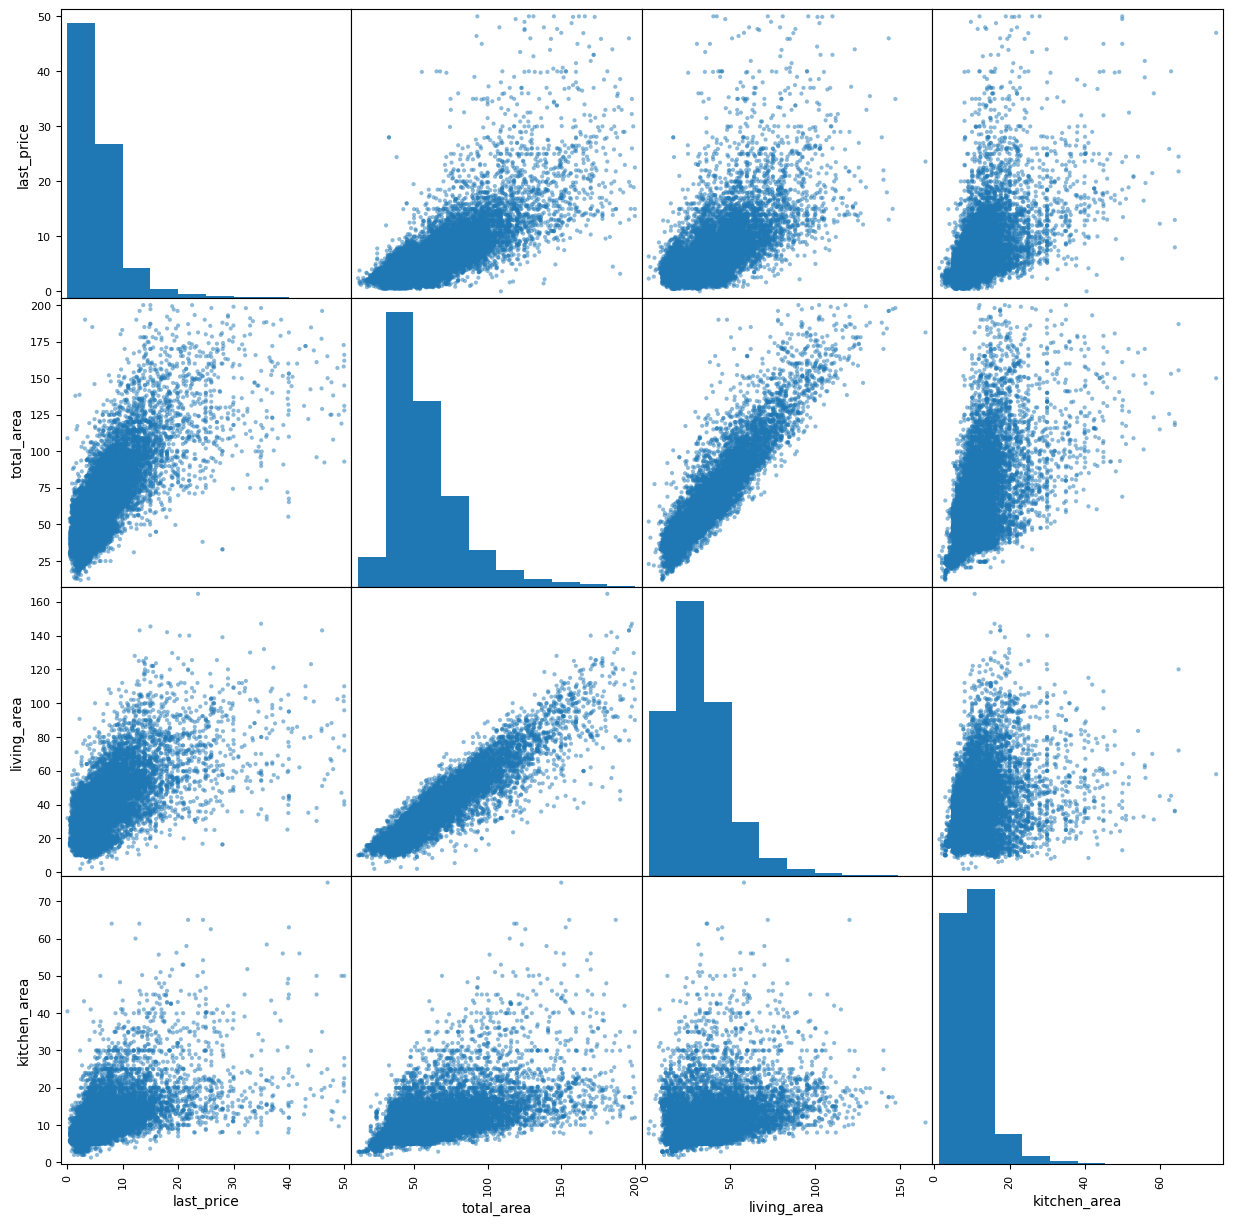

In [73]:
price_to_area = data[['last_price', 'total_area', 'living_area', 'kitchen_area']]
pd.plotting.scatter_matrix(price_to_area, figsize=(15, 15));

In [74]:
price_to_area.corr()

,last_price,total_area,living_area,kitchen_area
last_price,1.00,0.76,0.65,0.59
total_area,0.76,1.00,0.93,0.58
living_area,0.65,0.93,1.00,0.33
kitchen_area,0.59,0.58,0.33,1.00


Корреляция цены с площадью есть, что очевидно должно было быть, больше всего влияет общая площадь, менее жилая ещё меннее площадь кухни. Скорее всего цену формирует общая площадь, а жилая площадь и площадь кухни это зависимые от общей площади параметры, что мы видели ещё на стадии работы с пропусками

### Посчитаем среднюю цену одного квадратного метра по городам

Возмём среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

In [75]:
data.head()

,first_day_exposition,days_exposition,locality_name,city_centers_nearest,airports_nearest,parks_nearest,ponds_nearest,parks_around3000,ponds_around3000,number_of_rooms,number_of_balconies,total_area,living_area,kitchen_area,floors_total,floor,ceiling_height,is_apartment,is_studio,is_open_plan,last_price,total_images,price_for_m2,weekday_exposition,month_exposition,year_exposition,floor_type,city_centers_nearest_km
0,2019-03-07,NaN,санкт-петербург,"16,028.00","18,863.00",482.00,755.00,1.00,2.00,3,0,108.00,51.00,25.00,16,8,2.70,False,False,False,13.00,20,"120,370.37",3,3,2019,другой,16.00
1,2018-12-04,81.00,поселок шушары,"18,603.00","12,817.00",NaN,NaN,0.00,0.00,1,2,40.40,18.60,11.00,11,1,NaN,False,False,False,3.35,7,"82,920.79",1,12,2018,первый,19.00
2,2015-08-20,558.00,санкт-петербург,"13,933.00","21,741.00",90.00,574.00,1.00,2.00,2,0,56.00,34.30,8.30,5,4,NaN,False,False,False,5.20,10,"92,785.71",3,8,2015,другой,14.00
4,2018-06-19,121.00,санкт-петербург,"8,098.00","31,856.00",112.00,48.00,2.00,1.00,2,0,100.00,32.00,41.00,14,13,3.03,False,False,False,10.00,2,"100,000.00",1,6,2018,другой,8.00
5,2018-09-10,55.00,поселок янино-1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,30.40,14.40,9.10,12,5,NaN,False,False,False,2.89,10,"95,065.79",0,9,2018,другой,NaN


In [76]:
# сначала создадим топ 10 городов по количеству объявлений
top_ten_locations = data.groupby('locality_name')['locality_name'].count().sort_values(ascending=False).head(10)
# вычислим среднюю цену за квадратный метр и отсортируем по убыванию
data.query('locality_name in @top_ten_locations.index').groupby('locality_name')['price_for_m2'].mean().sort_values(ascending=False)

locality_name
санкт-петербург     112,249.66
пушкин              103,213.47
деревня кудрово      92,473.55
поселок парголово    90,332.26
поселок мурино       85,681.76
поселок шушары       78,677.36
колпино              75,333.30
гатчина              68,746.15
всеволожск           68,654.47
выборг               58,141.91
Name: price_for_m2, dtype: float64

Самый дорогой (115 тысяч за кв.м в среднем) город в списке топ 10 по количеству объявлений это Санкт-Петербург, самый дешовый (58 тысяч за кв.м в среднем) Выборг

### Вычеслим среднюю цену каждого километра до центра в объявлениях из Санкт-Петербурга

In [77]:
data.query('locality_name == "санкт-петербург"').pivot_table(
    index='city_centers_nearest_km', 
    values='price_for_m2', 
    aggfunc=('mean', 'median')
)

,mean,median
city_centers_nearest_km,,
0.00,"207,902.57","142,138.43"
1.00,"147,237.52","126,507.94"
2.00,"139,674.57","121,135.10"
3.00,"119,789.51","109,756.10"
4.00,"127,978.07","118,055.56"
5.00,"136,415.69","127,160.49"
6.00,"141,371.73","129,251.70"
7.00,"142,538.45","124,390.24"
8.00,"124,070.00","122,549.02"


 Цена обратно пропорциональна расстоянию от центра. Каждый километр от центра делает квартиру дешевле.
 Квартиры в центре имеют большую разницу между медианным значением и средним, то есть там больше выбросов с завышенными ценами, которые отражаются на среднем показателе, чем дальше квартира от центра, тем этот эффект ниже и цена стабилизируется 

## Общий вывод

### Краткий перечень проделанных действий:
- Мы проделали исследовательский анализ данных
- избавились от пропусков в столбцах с количеством балконов и статусе аппартаментов заполнив их нулями и булевым значением False соответственно
- избавились от пропусков применив в столбцах жилой площади, площади кухни, этажности дома метод MissForest 
- отформатировали и сгруппировали столбцы
- проверили наличие явных дубликатов, их не обнаружено
- удалили строки в которых отсутствует название населённого пункта
- удалили дублирующиеся названия населённых пунктов
- отсекли аномальные значения по нескольким показателям в которых имелись выбросы (высота потолков, цена, количество комнат, общая площадь)
- добавили новые столбцы (цена одного квадратного метра, день недели, месяц и год публикации, тип этажа квартиры, расстояние до центра города в километрах)

### В ходе исследования мы выяснили что:
- Общая площадь начинается около 30 метров, имеет пик в районе 50 метров и постепенно спадает к 150 метрам
- жилая площадь имеет пики возле 18, 30 и небольшой пик возле 43 метров. Скорее всего связано это с количеством комнат
- больше всего 1-комнатных квартир, немногим меньше 2-комнатных, после 4-5 комнат есть хвост
- высота потолков наиболее часто встречающиеся от 2.5 матра до 3 метров
- чаще квартиры не на первом и не на последнем этаже, а где-то между
- квартиры на первом этаже дешевле других
- по расстоянию от центра есть два крупных пика, на 5км и на 12 км. по всей видимости один пик это питер и другие города
- рядом с ээропортом почти никто не живёт (или не хочет об этом говорить в объявлении)
- основная масса парков находится примерно 500 м от жилья
- объявления чаще дают в рабочие дни и весной
- висят они около 95 дней по медиане. так же мы имеем пики на 45 и 60 дней, скорее всего это какае-то стандартное количество дней на которые даётся объявление
- цена слабо зависит от дня недели и месяца публикации обявления
- квартиры подешевели с 2014 года
- чем больше комнат тем квартиры дороже
- общая площадь сильно влияет на цену
- чем ближе к центру тем квартиры дороже, и тем больше выбросы по цене

В целом выводы оказались очевидными, но мы их проверили и подтвердили